In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_torus(n, m):
    # TODO: Return T_{nm}, the n x m torus grid.
    #       Each edge should have a color attribute.
    #       Color the vertical edges red and the horizontal blue.
    
    
    # This will just be the graph stored as a matrix
    # for convenience
    M = []
    T = nx.Graph()

    #Adding Nodes
    for i in range(n):
        row = []
        for j in range(m):
            T.add_node(i * m + j, label= "{}".format(i * m + j))
            row.append(i * m + j)
        M.append(row)

    #Adding Edges
    for i in range(n):
        for j in range(m):
            adj_nodes = {}
            element = i * m + j
            if not T.has_edge(element, M[i-1][j]):
                adj_nodes[(element, M[i-1][j])] = 'red'

            if not T.has_edge(element, M[i][j-1]):
                adj_nodes[(element, M[i][j-1])] = 'blue'

            if i+1 >= n and not T.has_edge(element, M[0][j]): 
                    adj_nodes[(element, M[0][j])] = 'red' 

            if i+1 < n and not T.has_edge(element, M[i+1][j]):
                adj_nodes[(element, M[i+1][j])] = 'red'

            if j+1 >= m and not T.has_edge(element, M[i][0]):
                adj_nodes[(element, M[i][0])] = 'blue'

            if j+1 < m and not T.has_edge(element, M[i][j+1]):
                adj_nodes[(element, M[i][j+1])] = 'blue'

            for edge, color in adj_nodes.items():
                T.add_edge(edge[0], edge[1], edge_color=color)

    return T


Graph with 200 nodes and 400 edges


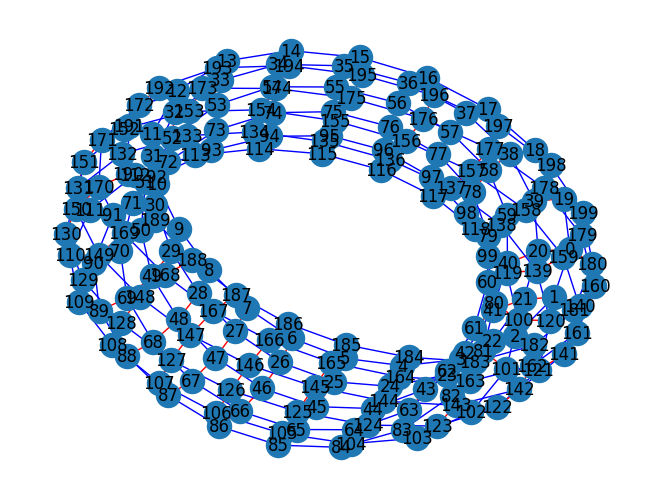

In [40]:
n = 10
m = 20

# This will just be the graph stored as a matrix
# for convenience
M = []
G = nx.Graph()

#Adding Nodes
for i in range(n):
    row = []
    for j in range(m):
        G.add_node(i * m + j, label= "{}".format(i * m + j))
        row.append(i * m + j)
    M.append(row)

#Adding Edges
for i in range(n):
    for j in range(m):
        adj_nodes = {}
        element = i * m + j
        if not G.has_edge(element, M[i-1][j]):
            adj_nodes[(element, M[i-1][j])] = 'red'
        
        if not G.has_edge(element, M[i][j-1]):
            adj_nodes[(element, M[i][j-1])] = 'blue'
        
        if i+1 >= n and not G.has_edge(element, M[0][j]): 
                adj_nodes[(element, M[0][j])] = 'red' 
        
        if i+1 < n and not G.has_edge(element, M[i+1][j]):
            adj_nodes[(element, M[i+1][j])] = 'red'
        
        if j+1 >= m and not G.has_edge(element, M[i][0]):
            adj_nodes[(element, M[i][0])] = 'blue'
        
        if j+1 < m and not G.has_edge(element, M[i][j+1]):
            adj_nodes[(element, M[i][j+1])] = 'blue'
        
        for edge, color in adj_nodes.items():
            G.add_edge(edge[0], edge[1], edge_color=color)

edge_colors = [G[u][v]['edge_color'] for u, v in G.edges()]
nx.draw(G, edge_color = edge_colors, with_labels=True)
print(G)

In [41]:
red = 0
blue = 0
colors = sum([0 if data['edge_color'] == 'blue' else 1 for u, v, data in G.edges(data=True)])

colors

200

In [ ]:
for i in range(n):
    for j in range(m):
        adj_nodes = []
        element = i * m + j
        adj_nodes.append((element, M[i-1][j]))
        adj_nodes.append((element, M[i][j-1]))
        if i+1 >= n:
            adj_nodes.append((element, M[0][j])) 
        else:
            adj_nodes.append((element, M[i+1][j]))
        if j+1 >= m:
            adj_nodes.append((element, M[i][0]))
        else:
            adj_nodes.append((element, M[i][j+1]))
        
        print("{}:".format(i*m + j),adj_nodes)

In [ ]:
edge_color = np.array([[tup[2] for tup in row] for row in Mat_col])
edge_color = edge_color.ravel()


In [ ]:
color_1d = [tup[2] for row in Mat_col for tup in row if len(row) > 0]
color_1d

In [ ]:
edge_color

In [5]:
T = nx.Graph()

T.add_nodes_from(range(2))
T.add_edge(0, 1, color = 'red')
nx.draw(T, edge_color=edge_color)

NameError: name 'edge_color' is not defined

We can use the same methods to draw the `karate` and `les_miserable` networks.

### Your turn!

Draw the karate network. Requirements:
- Use the `spring_layout` for positions.
- Nodes that have the value `"Officer"` in the `club` property are colored `tab:blue`, the ones with value `"Mr. Hi"` are colored `tab:green`.
- Node names (0-33) should be displayed in white font.
- Edges between inside each community should have the same color as the community.
- Edges across communities should be `tab:red`.

In [61]:
karate = nx.karate_club_graph()
les_miserables = nx.les_miserables_graph()

In [78]:
#Array for club: 1 if officer 0 if Mr.Hi
#club_arr = [1 if data['club'] == 'officer' else 0 for u, data in karate.nodes(data=True)]
#color for edge, red if edge between communities  blue for Officer green for Mr. Hi



for node1 in karate.nodes():
    for node2 in karate.nodes():
        if karate.has_edge(node1, node2):
            club1 = karate.nodes[node1]['club']
            club2 = karate.nodes[node2]['club']
            
            if club1 == club2:    
                #Are in the same club, check which
                
                if club1 == 'Mr. Hi':
                    karate[node1][node2]['color'] = 'green'
                else:
                    #nx.edge_attr(karate, 'color', node1, node2, 'blue')
                    karate[node1][node2]['color'] = 'blue'
            
            else:
                #Not in same club, color red
                
                karate[node1][node2]['color'] = 'red'


In [75]:
karate.nodes()[0]['club']

'Mr. Hi'

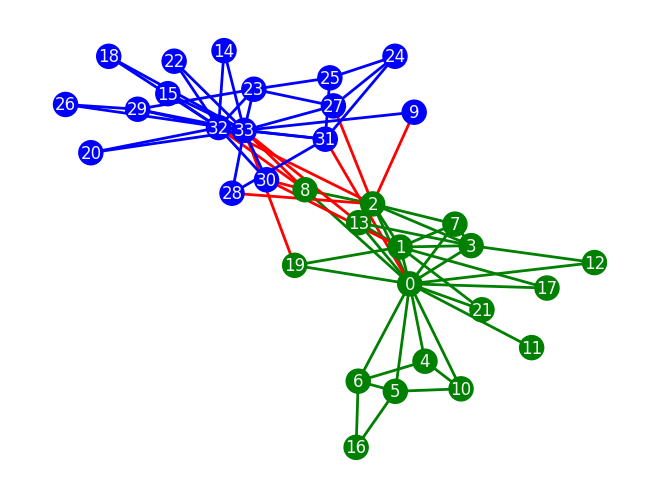

In [81]:
color_map = ['blue' if data['club'] == 'Officer' else 'green' for u, data in karate.nodes(data=True)]
edge_colors = [karate[u][v]['color'] for u, v in karate.edges()]
pos = nx.spring_layout(karate)
pc = nx.draw(karate, pos=pos, node_color=color_map, with_labels=True, font_color="whitesmoke", edge_color=edge_colors, width=2)
#nx.draw_networkx_labels(karate, pos, font_color="whitesmoke")


# Heat Equation and Spectral Embedding

In class we saw how following the dynamics of the Heat Equation will yield the vector $\mathbf{v} = \arg \min_{\mathbf{x} \perp 1} \frac{\mathbf{x}^T \mathbf{L}_G \mathbf{x}}{\mathbf{x}^T \mathbf{D}_G \mathbf{x}}$.

In this section you will implement the dynamic $\mathbf{x}_{t + 1} = \mathbf{x}_t - \frac{1}{2}\mathbf{D}_G^{-1} \mathbf{L}_G \mathbf{x}_t$ to approximate the second eigenvalue. Your goal is to approximate the second eigenvector by following this evolution.

### Heat Evolution

Complete the following function which takes in a graph $G$, an initial $\mathbf{x}_0 \in \mathbb{R}^{n \times d}$ and a target bound $\epsilon$ for the Dirichlet energy $\mathcal{U}(\mathbf{x}) = \|\mathbf{x} - \bar{x} \mathbf{1}\|_{\mathbf{D}_G}$ and returns the iterates $\mathbf{X} \in \mathbb{R}^{T \times n \times d}$.

In [97]:
from typing import Tuple

def Dirichlet_energy(x: np.array, xbar: float, deg_mat: np.ndarray) -> float:
    """
    Calculates the Dirichlet energy for a given state x and average xbar. 
    Also needs the Degree matrix from graph G
    
    Parameters
    ----------
        x: np.array
           The state vector.
        xbar: float
           The float value to which the system will converge.
        deg_mat: np.ndarray
            The degree matrix of the graph
    
    Returns
    -------
        Dirichlet : float
            The ``Energy" of the system. I.e. how har we are from uniform distribution
    """
    
    #Construct xbar_vec as column vector with size of the state vector
    xbar_vec = xbar * np.ones((1,len(x)))
    
    #check if state vector is a row vector
    if x.shape != xbar_vec.shape:
        x= x.T
        
    #Difference the state vector is from average element wise
    state_difference = x - xbar_vec
    
    Dirichlet = np.dot(state_difference, np.matmul(deg_mat, state_difference.T))
    Dirichlet *= 0.5
    
    return float(Dirichlet)

def heat_diffusion(G: nx.Graph, x_0: np.ndarray, epsilon: float=1e-6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Heat Diffusion
    
    Given a graph `G` and an initial `x_0` runs heat diffusion until $\mathcal{U}(\mathbf{x}) < \epsilon$.
    
    Parameters
    ----------
        G : nx.Graph
            Graph to run heat diffusion on.
        x_0 : np.ndarray
            Initial heat distribution x_0. Should be n x d array. d might be 1.
        epsilon : float
            Stopping criterion is the Dirichlet energy of the heat distribution to be less than epsilon.
    
    Returns
    -------
        x : np.ndarray
            The T x n x d evolution of x_0.
        y : np.ndarray
            Flow going through each edge. Should be T x m x d
        fx: np.ndarray
            The value of U(x(t)) at each time t.
    """
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    assert x_0.shape[0] == n, "x_0 does not have the right shape."
    d = x_0.shape[1]
    
    
    
    # TODO: You should fill out the following funtion.
    #       All transformations and intermediate results should be computed using matrix multiplications
    
    return np.zeros((1, n, d)), np.zeros((1, m, d)), np.array([0])

#x0 = np.random.rand(len(les_miserables), 2)
#x, y, fx = heat_diffusion(les_miserables, x0)

In [7]:
#Time evolution of x_0, for now, take d = 1
x = np.array(range(9))

G = generate_torus(3, 3)
#Need to make the degree matrix and Adjacency matrix 
deg_mat =  np.diag(np.array([node[1] for node in list(G.degree())]))
adj_mat = nx.adjacency_matrix(G)

deg_inv_mat = np.linalg.inv(deg_mat)
Lagrangian = deg_mat - adj_mat

x_temp = x[-1] - 0.5 * np.dot(np.matmul(deg_inv_mat,Lagrangian), x[-1])
#x_step = []

In [231]:
#x_0 = np.array([1, 2, 4, 1, 6, 8, 12, 0, 5],
#               [8, 6, 7, 5, 3, 0, 9, 10, 12])

x_0 = np.array([1, 2, 4, 1, 6, 8, 12, 0, 5])
y = np.zeros(*x_0.shape)
vol = nx.volume(G, G.nodes())
xbar = float((1/vol) * np.dot(np.ones((1, len(x_0))) @ deg_mat, x_0))

x_temp = x_0 - 0.5 * np.dot(np.matmul(deg_inv_mat,Lagrangian), x_0)
x = np.vstack([x_0, x_temp])

y_temp = x[-2] - x[-1]
y = np.vstack([y, y_temp])

while Dirichlet_energy(x[-1], xbar, deg_mat) > 1:
    x_temp = x[-1] - 0.5 * np.dot(np.matmul(deg_inv_mat,Lagrangian), x[-1])
    x = np.vstack([x, x_temp])
    
    y_temp = x[-2] - x_temp
    y = np.vstack([y, y_temp])
    print(Dirichlet_energy(x[-1], xbar, deg_mat))

#print(x)
#print(y)
#now iterate until dirichlet energy is less than ep. should calculate xbar and take it as const. what is xbar?

10.6669921875
3.937789916992188
1.5238864421844485
0.594373594969511


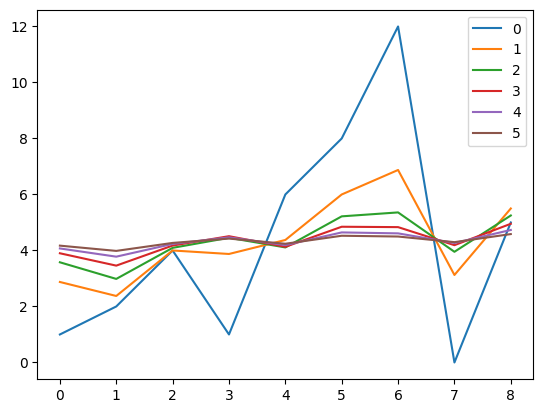

In [232]:
i =0
for line in x: 
    plt.plot(line, label = '{}'.format(i))
    i+=1
plt.legend()
plt.show()

In [93]:
#(deg_mat @ (x[0] - np.ones((len(G.nodes()), 1))))
np.subtract(x[0].T, np.ones((len(G.nodes()), 1)).T)

array([[-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]])

In [118]:
x_0 = np.array([[1, 2, 4, 1, 6, 8, 12, 0, 5],
               [8, 6, 7, 5, 3, 0, 9, 12, 0]])
x_0.shape[0]

2

In [238]:
x_0 = np.array([1, 2, 4, 1, 6, 8, 12, 0, 5])
num_initial_conditions = 3 # Number of initial conditions
num_iterations = 100 # Number of iterations

# Create an empty 3D array to store results
results = np.zeros((num_initial_conditions, num_iterations, len(x_0)))

# Loop through different initial conditions
for ic in range(num_initial_conditions):
    # Set the initial condition
    x = [x_0]
    y = []

    # Perform the optimization loop
    for iteration in range(num_iterations):
        while Dirichlet_energy(x[-1], xbar, deg_mat) > 1:
            x_temp = x[-1] - 0.5 * np.dot(np.matmul(deg_inv_mat, Lagrangian), x[-1])
            x.append(x_temp)

            y_temp = x[-2] - x_temp
            y.append(y_temp)

        results[ic, iteration] = x[-1] # Store the result for this initial condition and iteration

In [242]:
results[:,0]


array([[4.17276001, 3.98495483, 4.27008057, 4.42446899, 4.24057007,
        4.5256958 , 4.49813843, 4.29763794, 4.58569336],
       [4.17276001, 3.98495483, 4.27008057, 4.42446899, 4.24057007,
        4.5256958 , 4.49813843, 4.29763794, 4.58569336],
       [4.17276001, 3.98495483, 4.27008057, 4.42446899, 4.24057007,
        4.5256958 , 4.49813843, 4.29763794, 4.58569336]])

In [178]:
x.shape[1:]

(9, 1)

In [173]:
x_temp = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
x[1, :, 0] = x_temp
#evolutions[0] = np.concatenate((evolutions[0], new_condition), axis=0)
#xarr
x[1, :, 0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [216]:
x_0 = np.array([[1, 2, 4, 1, 6, 8, 12, 0, 5],
               [8, 6, 7, 5, 3, 0, 9, 12, 0]])

x_tens = np.zeros((2, 9, 2))
x_tens[0, :, 0] = x_0[0]
x_tens[0, :, 1] = x_0[1]
#x_tens[0] = np.append(x_tens[0, :, 0], x_temp, axis = 0)
np.append(x_tens[:, :, 0], [x_temp], axis = 1)
#x_tens[:, :, 0] = np.vstack([x_tens[0, :, 0], x_temp])
#x_tens

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 1